In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%autosave 0
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.stats
import pandas as pd

from IPython.display import display
import ipywidgets as widgets
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)
from scipy.special import erf
gaussian_pdf = lambda x, mu=0, s=1: np.exp(-0.5*(x-mu)**2/s**2)/(s*np.sqrt(2*np.pi))
gaussian_cdf = lambda x, mu=0, s=1: 0.5 + 0.5*erf((x-mu)/(s*np.sqrt(2)))

Autosave disabled


# Mundo de datos

Los avances tecnológicos recientes nos permiten **medir, almacenar y enviar** datos de toda índole

- Operaciones industriales
- Comercio
- Entretenimiento 
- Datos públicos y gubernamentales
- Datos médicos
- Ciencia: Genómica, Astronomía, Simulaciones, etc
- Vehículos autónomos
- Internet de las cosas

> Los datos crudos tienen poco valor, necesitamos extraer información a partir de los datos

- ¿Cómo se comportan mis datos? ¿Cúales son las observaciones más cómunes? ¿Qué datos son más relevantes?
- ¿Cúal es la diferencia entre dos muestras? ¿Son las diferencias que observo reales o productos del ruido?
- ¿Qué tan probable es que ocurra el suceso $X$? 
- ¿Qué tan arriesgado es tomar la decisión $Y$?

> La **estadística** nos da herramientas para entender los procesos y tomar decisiones


<img src="https://proxy.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1600%2F1*ufWDxL-5ogd22Rg_37rakw.png&f=1">


En esta clase aprenderemos a usar [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) y [`numpy.random`](https://docs.scipy.org/doc/numpy/reference/routines.random.html) para resolver problemas de **inferencia estadística**

Pero antes, algunos fundamentos:

## Fundamentos: Incerteza

Fuentes de incerteza:
1. Estocasticidad inherente: Sistemas con [dinámicas aleatorias](https://en.wikipedia.org/wiki/Uncertainty_principle)
1. Observación incompleta: Sistema determinista que parece estocástico [cuando no se observa completamente](https://en.wikipedia.org/wiki/Monty_Hall_problem)
1. Modelamiento incompleto: Los [supuestos y aproximaciones del sistema](https://en.wikipedia.org/wiki/Discretization) introducen incerteza 

¿Cómo representamos la incerteza?

> Teoría de probabilidades

Nos proporciona reglas formales para determinar la verosimilitud de una proposición versus otras

## Fundamentos: Variables aleatorias 

- **V.A.** Es una variable que, al ser observada, puede tomar diferentes valores

    - La denotamos como $X$
    
    - Sus observaciones (realizaciones) son $x\sim X$
    
    - Sus realizaciones tienen un dominio $x \in \mathcal{X}$
    
    - La probabilidad de observar $x$ es $P(X=x)$
    
    - Puede ser discreta o continua
    

    
- El comportamiento de $X$ está dictado por 
    - Función de masa de probabilidad (para $X$ discreta)
    
    $P(X=x) \in [0, 1]$
    
    $\sum_{x\in\mathcal{X}} P(X=x) = 1$    
    
    - Función de densidad de probabilidad (para $X$ continua)
    
    $f(x) \geq 0$
    
    $\int_{x\in\mathcal{X}} f(x) \,dx = 1$, 
    
    $P(a\leq X \leq b) = F(b) - F(a) = \int_{a}^{b} f(x) \,dx$
    
        - Función de densidad acumulada: 
        
        $F(a)  = \int_{-\infty}^{a} f(x) \,dx$
        
        
> **Importante:** Sólo en el caso discreto la distribución puede interpretarse como probabilidad

<IPython.core.display.Javascript object>


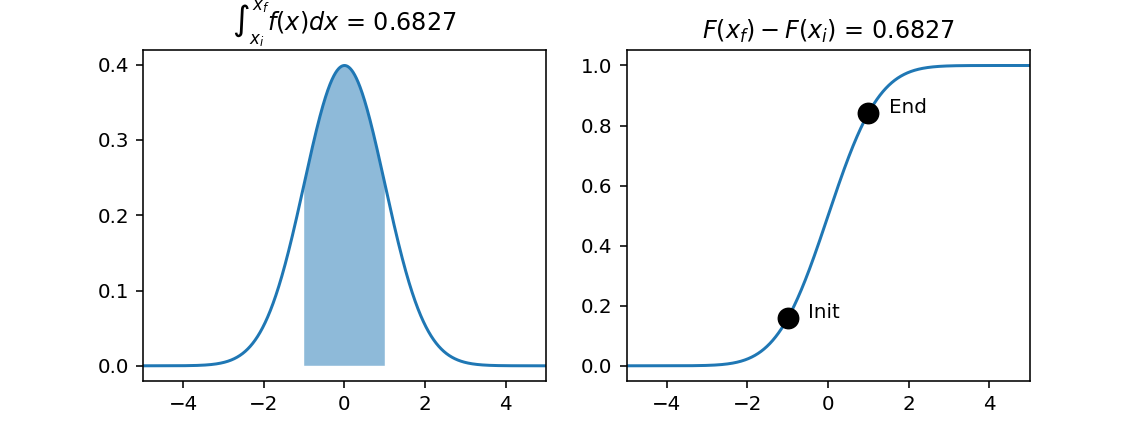

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), description='$x_i, x_f$', max=5.0, min=-5.0), Output…

In [63]:
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(8, 3))
dt=1e-4; x = np.arange(-5, 5, step=dt)

def update_plot(x_r):
    xi, xf = x_r
    for axis in ax:
        axis.cla(); 
        axis.set_xlim([-5, 5]);
    ax[0].plot(x, gaussian_pdf(x)); ax[1].plot(x, gaussian_cdf(x));
    xrange = np.arange(xi, xf, step=dt)
    ax[0].fill_between(xrange, 0, gaussian_pdf(xrange), alpha=0.5)
    ax[1].scatter([xi, xf], [gaussian_cdf(xi), gaussian_cdf(xf)], s=100, c='k', zorder=100)
    ax[1].text(xi+0.5, gaussian_cdf(xi), "Init"); ax[1].text(xf+0.5, gaussian_cdf(xf), "End")
    ax[0].set_title("$\int_{x_i}^{x_f} f(x) dx$ = %0.4f" %(np.sum(gaussian_pdf(xrange))*dt))
    area = gaussian_cdf(xf) - gaussian_cdf(xi)
    ax[1].set_title("$F(x_f) - F(x_i)$ = %0.4f" %(area if area >= 0 else 0))

widgets.interact(update_plot, 
         x_r=widgets.FloatRangeSlider(description=r"$x_i, x_f$", min=-5, max=5, value=[-1, 1]));

## Probabilidad conjunta, marginal y condicional

La probabilidad de dos eventos $X=x$ e $Y=y$ se caracteriza con la distribución conjunta $P(X, Y)$

A partir de la conjunta se pueden obtener la probabilidad marginal de $X$ (o de $Y$)

$$
P(X=x) = \sum_{y \in \mathcal{Y}} P(X=x, Y=y) 
$$

Usando la conjunta y las marginales podemos obtener las probabilidades condicionales

$$
P(Y=y|X=x) = \frac{P(X=x, Y=y)}{P(X=x)}
$$

(ssi $P(X=x) \neq 0$)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x = np.arange(-4, 5, 1)
y = np.arange(-4, 5, 1)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
Z[-3, 2:-2] = 1
Z[2, 2:-2] = 1
Z[2:-2, 4] = 1
Z = Z/np.sum(Z)

ax.bar(x, np.sum(Z, axis=1), zdir='x', zs=-4)
ax.bar(y, np.sum(Z, axis=0), zdir='y', zs=5)
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z.ravel()), 1, 1, Z.ravel())
ax.set_xlim([-4, 5]); ax.set_xlabel('X')
ax.set_ylim([-4, 5]); ax.set_ylabel('Y')

ax2 = fig.add_subplot(1, 2, 2)

def update_plot(idx):
    ax2.cla()
    ax2.bar(y, Z[:, idx]/np.sum(Z[:, idx]))
    ax2.set_title("P(Y|X={0})".format(x[idx]))
    ax2.set_ylim([0, 0.55])
    ax2.set_xlim([-4, 4])
    
widgets.interact(update_plot, idx=IntSlider_nice(min=0, max=len(x), value=4));

## Independencia

Si dos V.A. son independientes podemos escribir
$$
\begin{align}
P(x, y)  &= P(x)P(y|x)\nonumber \\
&= P(x)P(y) \nonumber
\end{align}
$$

> Saber que ocurrió $x$ no me sirve da nada para saber si ocurrió $y$
 

Dos V.A. son condicionalmente independientes si

$$
P(x, y|z)  = P(x|z)P(y|z)
$$


## Regla de la cadena

Podemos descomponer una probabilidad conjunta como

$$
\begin{align}
P(x_1, x_2, x_3) &= P(x_3|x_2, x_1) P(x_1, x_2) \nonumber \\
&= P(x_3|x_2, x_1) P(x_2|x_1) P(x_1) \nonumber 
\end{align}
$$

## Ley de probabilidad total

Si el espacio de probabilidad está particionado en $N$ pedazos y se conocen las probabilidades condicionales $P(X=x|Y=y_i)$ podemos calcular la probabilidad del evento $x$ usando

$$
P(X=x) = \sum_{i=1}^N P(X=x|Y=y_i) P(Y=y_i)
$$

## Teorema de Bayes

Podemos escribir 

- la probabilidad de un evento $y$ dado condiciones $x$: $p(y|x)$ 
- en función de nuestro conocimiento *a priori* sobre $y$: $p(y$)
- y de la verosimilitud de que se observen dichas condiciones si $y$ ocurriese: $p(x|y)$

como

$$
P(y | x) = \frac{P(x|y) P(y)}{P(x)} = \frac{P(x|y) P(y)}{\sum_{y\in\mathcal{Y}} P(x|y) P(y)}
$$

## Descriptores de las distribuciones

Podemos describir una variable aleatoria $X$ con $x \sim f(x)$ usando

### Valor esperado

El valor medio de $X$

$$
\mathbb{E}_{x\sim f(x)} [ X ] = \int_{x\in \mathcal{X}} x f(x)  \,dx
$$

### Varianza 

La dispersión de $X$ en torno a su valor medio

$$
\text{Var}[X]  = \mathbb{E}_{x\sim f(x)} \left[\left(X - \mathbb{E}[X] \right)^2 \right]
$$

la relación lineal entre $X$ e $Y$

$$
\text{Cov}[X, Y]  = \mathbb{E}_{x\sim f_X(x), y\sim f_Y(y)} \left[\left(X - \mathbb{E}[X] \right) \left(Y - \mathbb{E}[Y] \right)^T \right]
$$


### Momentos estadísticos

$$
m_k [X] = \mathbb{E}_{x\sim f(x)} [ X^k ]
$$

- Tercer momento: Simetría 
- Cuarto momento: Cúrtosis


In [ ]:
fig, ax = plt.subplots(2, figsize=(7, 3), tight_layout=True)
x = np.linspace(-4, 4, num=1000)

def update_plot(loc, scale, skew, shape):
    distribution1 = scipy.stats.skewnorm(skew, loc=loc, scale=scale)
    distribution2 = scipy.stats.gennorm(shape, loc=loc, scale=scale*np.sqrt(2))
    [ax_.cla() for ax_ in ax]
    ax[0].plot(x, distribution1.pdf(x))
    ax[1].plot(x, distribution2.pdf(x))
    
widgets.interact(update_plot, loc=FloatSlider_nice(min=-3, max=3), 
                 scale=FloatSlider_nice(min=0.01, max=2., value=1), 
                 skew=FloatSlider_nice(min=-5, max=5, value=0),
                 shape=FloatSlider_nice(min=0.1, max=10, value=2));

## Algunas distribuciones de probabilidad

| Distribución | Fenomeno que representa | Ejemplo |
| --- | --- | --- |
| **Bernoulli** | Evento binario  | Lanzamiento de una moneda |
| **Binomial** | Multiples eventos binarios independientes | |
| **Categórica** | Evento con $k$ valores posibles | Lanzamiento de un dado, Ruleta |
| **Poisson** | Conteo de eventos ocurridos en un período de tiempo | Cantidad de alumnos que llegan entre 9:50 y 10:00| 
| **Exponencial** | Valor continuo positivo | Tiempo de espera entre eventos|
| **Gamma** | Valor continuo positivo | Tiempos de espera hasta que ocurren $n$ eventos|
| **Beta** | Valor continuo en $[0, 1]$ |  Tiempo para completar una tarea, proporciones|
| **Normal/Gaussiana** | Valor continuo ubicado en la vecindad de un valor central| [Demasiados](https://galtonboard.com/probabilityexamplesinlife)|
| **Uniforme** | Valor discreto/continuo acotado a un rango, todos con igual probabilidad de ocurrencia| |

<img src="https://thumbs.gfycat.com/AggressiveAromaticBuckeyebutterfly-size_restricted.gif">

***

Podemos usar `np.random` para generar números aleatorios con distintas propiedades
- `randn` : Números reales con distribución normal estándar
- `rand`: Números reales con distribución uniforme en $[0, 1]$
- `randint(low=1, high=10)`: Números enteros con distribución uniforme entre $[0, 10]$

Podemos usar `scipy.stats` para generar datos de una distribución específica
- [continua](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions)
- [multivariada](https://docs.scipy.org/doc/scipy/reference/stats.html#multivariate-distributions)
- [discreta](https://docs.scipy.org/doc/scipy/reference/stats.html#discrete-distributions)

Las distribuciones tienen un constructor específico y métodos
- `pdf`/`pmf(x)` Retorna la distribución de probabilidad evaluada en $x$
- `cdf(x)` Distribución acumulada evaluada en $x$
- `ppf(p)` Inverso de la distribución acumulada
- `rvs(size=100)` Retorna $100$ muestras a partir de la distribución

## En detalle: Gaussiana/Normal Multivariada

- Dominio $x\in \mathbb{R}^d$
- Parámetros: 
    - Media $\mathbb{E}[X] = \mu \in \mathbb{R}^d$ 
    - Covarianza $\mathbb{E}[(X-\mu)(X-\mu)^T] = \Sigma \in \mathbb{R}^{d\times d}$ (semidefinida positiva)
- Función de densidad de probabilidad
$$
p(x| \mu, \Sigma) = \frac{1}{ \sqrt{(2 \pi)^d} |\Sigma |} \exp \left ( -\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) \right)
$$

- Casos especiales
    - Covarianza diagonal: $\Sigma = [\sigma_1^2, \sigma_2^2, \ldots, \sigma_d^2] I$
    - Covarianza isotrópica (esférica): $\Sigma = \sigma^2 I$
    - Normal estándar: $\mu = [0, 0, \ldots, 0]$, $\Sigma = I$

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 4))

def update_plot(mu1, mu2, s1, s2, rho, seed):
    ax.cla()
    np.random.seed(seed)
    mu = np.array([mu1, mu2]); s = np.diag(np.array([s1, s2]))
    rot_mat = [[np.cos(rho), -np.sin(rho)], [np.sin(rho), np.cos(rho)]]
    L = np.dot(rot_mat, s)
    #x = np.random.multivariate_normal(mean=mu, cov=np.dot(L, L.T), size=5000)
    dist = scipy.stats.multivariate_normal(mean=mu, cov=np.dot(L, L.T))
    x = np.linspace(-3, 3)
    X, Y = np.meshgrid(x, x)
    Z = dist.pdf(np.dstack((X, Y)))
    ax.contour(X, Y, Z)
    xhat = dist.rvs(size=5000)
    ax.scatter(xhat[:, 0], xhat[:, 1], s=5, alpha=0.5)
    ax.set_xlim([-3, 3]); ax.set_ylim([-3, 3])
    ax.set_aspect('equal')
    
widgets.interact(update_plot, mu1=FloatSlider_nice(min=-2, max=2), mu2=FloatSlider_nice(min=-2, max=2),
                 s1=FloatSlider_nice(value=1, min=0.1, max=2), s2=FloatSlider_nice(value=1, min=0.1, max=2),
                 rho=FloatSlider_nice(value=0, min=-np.pi/2, max=np.pi/2), seed=IntSlider_nice());

## Ley de los grandes números

Si $X_1, X_2, \ldots, X_N$ son V.A independientes e idénticamente distribuidas (iid) con media $\mu$  entonces su promedio

$$
\bar X = \frac{1}{N} (X_1 + X_2 + \ldots + X_N)
$$

tiende a $\bar X \to \mu$ cuando $N \to \infty$

## Teorema central del límite

Si $X_1, X_2, \ldots, X_N$ son V.A iid, entonces su promedio 

$$
\bar X \sim \mathcal{N}(\mu, \sigma^2/N)
$$

> Sin importar su distribución original, si sumo muchas VA iid entonces la suma se distribuye normal

## En detalle: Distribución multinomial

- Dominio $x \in \{0, 1, \ldots n\}^k$
- Parámetros: 
    - $n>0$: Número de experimentos 
    - ${p_1, p_2, \ldots, p_k}$: Probabilidad de las categorías donde $\sum_i p_i = 1$
- Función de masa de probabilidad
$$
p(x| m, \{p\}) = \frac{n!}{x_1! x_2! \cdots x_k!} \prod_{i=1}^k {p_i}^{x_i}
$$

- Casos especiales
    - $k = 2$: Distribución binomial
    - $k = 2$ y $n = 1$: Distribución Bernoulli

In [ ]:
dist = scipy.stats.multinomial(n=2, p=[1/6]*6)
dist.rvs(size=1)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

def update_plot(k):
    ax.cla()
    ax.set_title("Promedio de {0} lanzamiento/s de dado".format(k+1))
    dist = scipy.stats.multinomial(n=k+1, p=[1/6]*6)
    repeats = dist.rvs(size=1000)/(k+1)
    average_dice = np.sum(repeats*range(1, 7), axis=1)
    ax.hist(average_dice, bins=12, density=True)
    ax.set_xlim([1, 6])
update_plot(0)
#anim = animation.FuncAnimation(fig, update_plot, frames=20, interval=300, 
#                               repeat=True, blit=False)

# Estadística

La estadística busca:

> Describir fenómenos complejos a partir de observaciones parciales 

> Inferir propiedades de una población basándonos en una muestra

> Usar datos para responder preguntas y tomar decisiones

La estadística es:

> Disciplina científica dedicada al desarrollo y estudio de métodos para recopilar, analizar y extraer información de los datos


## Estadística descriptiva

Sea una muestra de datos. Para entenderla mejor podemos empezar describiendola:
- ¿Discreto o continuo? ¿No-negativo?
- ¿Dónde está localizada? **Media**
- ¿Cuál es su disperción? **Varianza**
- ¿Son las colas iguales o distintas? **Simetría** (*Skewness*)
- ¿Son las colas ligeras o pesadas? **Curtosis** (*Kurtosis*)
- ¿Tiene una moda o múltiples modas?
- ¿Cuantiles? ¿Percentiles? 
- ¿Existen *outliers*?

Podemos responder estas preguntas usando [estadísticos de resumen](https://docs.scipy.org/doc/scipy/reference/stats.html#summary-statistics)

In [ ]:
x = np.linspace(-11, 10, num=1000)
px = 0.7*gaussian_pdf(x, mu=-4, s=2) + 0.3*gaussian_pdf(x, mu=3, s=2)
N = 1000; 
np.random.seed(0)
hatx = np.concatenate((-4 + 2*np.random.randn(int(0.7*N)), 
                       (3 + 2*np.random.randn(int(0.3*N)))))

scipy.stats.describe(hatx)

En ciertos casos podemos responder estas preguntas graficamente usando:

### Histograma

- Es una representación numérica de una distribución
- Nos permite visualizar las características de la distribución
- Se construye dividiendo el dominio en **bines** y contando los datos que caen en cada **bin**
- Está definido por la posición y tamaño de los bines
- Método no-paramétrico para representar distribuciones

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))

def update_plot(nbins): 
    ax.cla()
    ax.plot(x, px, 'k-', linewidth=4, alpha=0.8)
    hist, bin_edges = np.histogram(hatx, bins=nbins, density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1:] - bin_edges[:-1], 
           edgecolor='k', align='edge', alpha=0.8)
    ax.set_xlabel('x')
    
widgets.interact(update_plot, nbins=SelSlider_nice(options=[2, 5, 10, 15, 20, 50], value=5));

### Kernel density estimation (KDE)

Mismo objetivo que el histograma pero
1. Cada dato es "su propio bin"
1. Los bines se pueden traslapar
1. No se escoge la posición o fronteras de bines, solo su ancho

Para un set de observaciones unidimensionales $\{x_i\}_{i=1,\ldots, N}$ con dominio continuo

$$
\hat f_h(x) = \frac{1}{Nh} \sum_{i=1}^N \kappa \left ( \frac{x - x_i}{h} \right)
$$

donde 
- $h$ es el **ancho de banda del kernel** o **tamaño de kernel**
- $\kappa(u)$ es una **función de kernel** que debe ser positiva, con media cero e integrar a la unidad

Por ejemplo  el famoso kernel Gaussiano

$$
\kappa(u) = \frac{1}{\sqrt{2\pi}} \exp \left ( - \frac{u^2}{2} \right),
$$

Ojo: 
- Usar un kernel gaussiano no es lo mismo que asumir que los datos se distribuyen gaussianos
- Se puede usar un kernel gaussiano en datos que no se distribuyen gaussianos

In [ ]:
from sklearn.neighbors.kde import KernelDensity
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, px, 'k-', linewidth=4, alpha=0.8)
ax.scatter(hatx, np.zeros_like(hatx), marker='+', c='k', s=20, alpha=0.1)
ax.set_xlabel('x')
line_kde = ax.plot(x, np.zeros_like(x))
#hs = 0.9*np.std(hatx)*N**(-1/5)
def update(k): 
    kde = scipy.stats.gaussian_kde(hatx, bw_method=lambda kde: k*kde.silverman_factor() )
    line_kde[0].set_ydata(kde.pdf(x))
    
widgets.interact(update, k=SelSlider_nice(description="$k=h/h_s$", options=[1/8, 1/4, 1/2, 1, 2, 4], value=1));

Más opciones de kernels en [`sklearn.neighbors.KernelDensity`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity)

# Inferencia estadística

> Extraer conclusiones a partir de hechos a través de una premisa científica

- Hechos: Datos
- Premisa: Modelo probabilístico
- Conclusión: Una cantidad no observada que es interesante

> Cuantificar la incerteza de la conclusión dado los datos y el modelo 

Tareas inferenciales
1. Ajustar un modelo: **Máxima verosimilitud**
1. Verificar el modelo: **Intervalo de confianza**
1. Responder una pregunta usando el modelo: **Test de hipótesis**

## Ajuste de modelos paramétricos

Se refiere a aquellos modelos que explicitan una distribución de probabilidad

### Ejemplo: La pesa defectuosa

- Mi pesa está defectuosa
- Luego de comer mido $M$ veces mi peso obteniendo un conjunto de observaciones $\{x_i\}$
- El objetivo es encontrar mi peso real $\hat x$. 

Puedo modelar mis observaciones como
$$
x_i = \hat x + \varepsilon_i
$$
donde $\varepsilon_i$ corresponde al ruido del instrumento

Asumamos que $\varepsilon_i \sim \mathcal{N}(0, \sigma_\varepsilon^2)$

es decir que el ruido es
- Independiente
- Gaussiano
- Con media cero y varianza $\sigma_\varepsilon^2$

Con esto podemos escribir la probabilidad de observar $x_i$ dado un cierto valor $\hat x$ como

$$
p(x_i|\hat x) = \mathcal{N}(\hat x, \sigma_\varepsilon^2)
$$

> Mi modelo tiene dos parámetros: $\hat x$ y $\sigma_\varepsilon^2$

Si **asumimos** que las observaciones son independientes e identicamente distribuidas (iid), podemos escribir la probabilidad de observar el conjunto completo como 

$$
\begin{align}
p(x_1, x_2, \ldots, x_M| \hat x) &= \prod_{i=1}^M p(x_i|\hat x) \nonumber \\
&= \prod_{i=1}^M  \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}  \exp \left ( - \frac{1}{2\sigma_\varepsilon^2} (x_i - \hat x)^2 \right) = \mathcal{L}(\hat x)  \nonumber
\end{align}
$$

> Esto se conoce como la **verosimilitud** de los parámetros dado el conjunto de observaciones

Podemos buscar los parámetros que hacen mi modelo más "creible" **maximizando la verosimilitud**


$$
\max_{\hat x}  \mathcal{L}(\hat x) = \max_{\hat x}  \log \mathcal{L}(\hat x) = -\frac{1}{2} \log(2\pi\sigma_\varepsilon^2)M - \frac{1}{2\sigma_\varepsilon^2} \sum_{i=1}^M (x_i - \hat x )^2
$$

Como el logaritmo es monotónico conviene maximizar el log de la verosimilitud

Si derivamos e igualamos a cero

$$
\begin{align}
-\frac{1}{2\sigma_\varepsilon^2} \sum_{i=1}^M 2(x_i - \hat x ) &= 0 \nonumber \\
\hat x &= \frac{1}{M} \sum_{i=1}^M x_i \nonumber 
\end{align}
$$

> El estimador de máxima verosimilitud para la media de una Gaussiana es el clásico promedio muestral

Si hicieramos lo mismo para la varianza encontraríamos

$$
\sigma_\epsilon^2 = \frac{1}{M} \sum_{i=1}^M (x_i - \hat x)^2
$$

> Que es la varianza muestreal (sesgada)

# Estimación de máxima verosimilitud

El procedimiento que acabamos de ver se llama *maximum likelihood estimation* (MLE)

Procedimiento

1. Definir los supuestos del problema, el modelo (distribución) y sus parámetros $\theta$
1. Escribir el **logaritmo de la verosimilud** de los parámetros $\log \mathcal{L}(\theta)$
1. Encontrar $\theta$ que maximiza 
$$
\hat \theta = \text{arg}\max_\theta \log \mathcal{L}(\theta)
$$


Las distribuciones de  `scipy.stats` tienen los métodos
- `fit (data)` Ajusta una distribución continua a datos usando MLE
- `expect (func)` Valor esperado de una función c/r a la distribución
- `interval (alpha)` Cotas para el intervalo que contiene un porcentaje $\alpha$ de la distribución

Para distribuciones complicadas sin solución analítica se pueden usar métodos iterativos

### Ejemplo: Ajustando y comparando distintas distribuciones

Observemos la siguiente distribución, ¿Qué características resaltan? ¿Qué distribución sería apropiado ajustar?

<IPython.core.display.Javascript object>


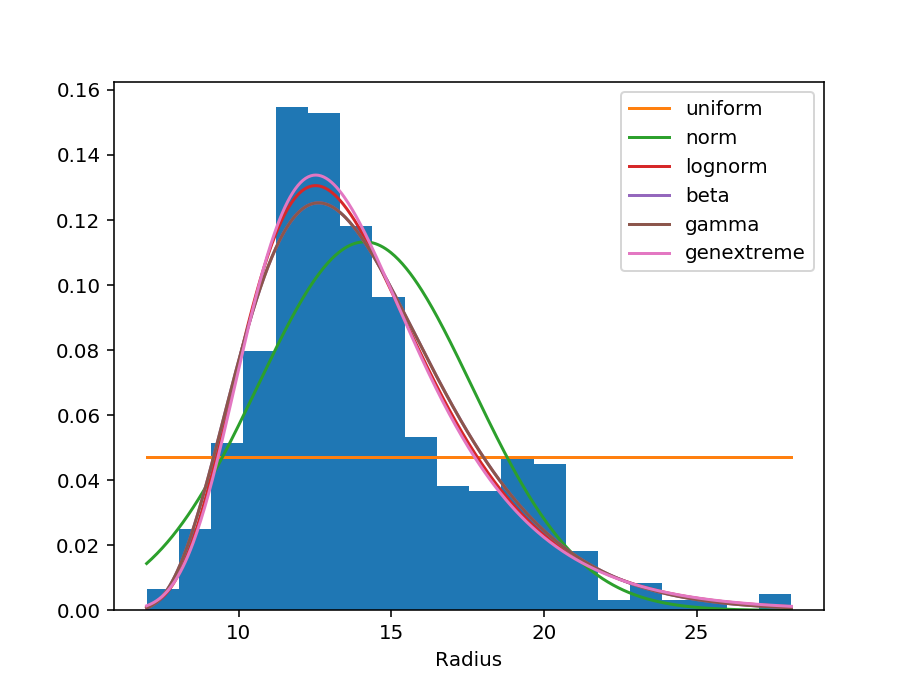

In [5]:
from sklearn import datasets

ds = datasets.load_breast_cancer()

radius = ds['data'][:, 0]

fix, ax = plt.subplots()

ax.hist(radius, bins = 20, density = True)
ax.set_xlabel('Radius')

x_plot = np.linspace(np.amin(radius), np.amax(radius), num = 500)

for dist in [scipy.stats.uniform, scipy.stats.norm, scipy.stats.lognorm, scipy.stats.beta, scipy.stats.gamma, scipy.stats.genextreme]:    

    # MLE for get params
    params = dist.fit(radius)

    #print(params)
    
    fitted_dist = dist(*params[:-2], loc=params[-2], scale=params[-1]).pdf(x_plot)

    ax.plot(x_plot, fitted_dist, label = dist.name)
    
ax.legend()

<IPython.core.display.Javascript object>


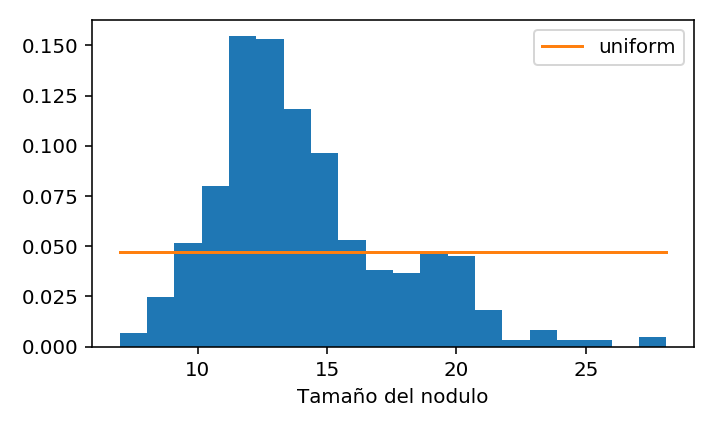

In [6]:
from sklearn import datasets
data_set = datasets.load_breast_cancer()
x, y = data_set['data'][:, 0], data_set['target']
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(x, bins=20, density=True)
ax.set_xlabel('Tamaño del nodulo');

In [7]:
from collections import Counter
Counter(y)

Counter({0: 212, 1: 357})

Podemos probar varias distribuciones y observar el resultado

¿Cómo medir la bondad del ajuste?

In [8]:
x_plot = np.linspace(np.amin(x), np.amax(x), num=500)
dist = scipy.stats.uniform
params = dist.fit(x)
print(dist.name)
print(params)
p_plot = dist(*params[:-2], loc=params[-2], scale=params[-1]).pdf(x_plot)
ax.plot(x_plot, p_plot, label=dist.name)
plt.legend();

uniform
(6.981, 21.128999999999998)


### Bondad de ajuste

Podemos usar el test chi-cuadrado, el [test de Akaike](https://en.wikipedia.org/wiki/Akaike_information_criterion), el test no-paramétrico de Kolmogorov-Smirnov (KS) o gráficos QQ para medir que tan bien se ajusta nuestra distribución teórica a los datos

El test KS nos permite comparar que tan distinta es una distribución continua empírica de una teórica comparando sus CDFs: [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)

- Require que los datos estén estandarizados 

$$
Z = \frac{X - \mu_X}{\sigma_X}
$$

- Retorna un estadístico: Mientras más cerca a cero, mejor es el ajuste
- También retorna un p-value: Si es menor que $\alpha$ entonces rechazo la hipótesis nula de que las distribuciones son iguales con un $1-\alpha$ de confianza. Veremos test de hipótesis más adelante


In [26]:
radius_std = (radius  - np.mean(radius))/np.std(radius)

#ks_test = []

for dist in [scipy.stats.uniform, scipy.stats.norm, scipy.stats.lognorm, scipy.stats.beta, scipy.stats.gamma, scipy.stats.genextreme]:    
    
    # get best params using MLE
    params = dist.fit(radius_std)

    # Get dist with optimized params
    fitted_dist = dist(*params[:-2], loc = params[-2], scale = params[-1])

    # KS test
    print('{0}:\n\n{1}\n'.format(dist.name, scipy.stats.kstest(rvs = radius_std, cdf = fitted_dist.cdf)))
    
#ks_test

uniform:

KstestResult(statistic=0.3357488242157285, pvalue=1.056667697927804e-57)

norm:

KstestResult(statistic=0.11273020428287467, pvalue=9.379762733102834e-07)

lognorm:

KstestResult(statistic=0.04572819688251406, pvalue=0.17957471985392512)

beta:

KstestResult(statistic=0.054501344732978185, pvalue=0.06558308939085651)

gamma:

KstestResult(statistic=0.05501235745302735, pvalue=0.0615118848336949)

genextreme:

KstestResult(statistic=0.041928585531955775, pvalue=0.2630460666158991)



In [9]:
x_std = (x-np.mean(x))/np.std(x)
ks_res = []
for dist in [scipy.stats.norm, scipy.stats.lognorm, scipy.stats.beta, scipy.stats.gamma, scipy.stats.genextreme]:    
    params = dist.fit(x_std)
    fitted_dist = dist(*params[:-2], loc=params[-2], scale=params[-1])
    ks_res.append(scipy.stats.kstest(rvs=x_std, cdf=fitted_dist.cdf))
    print(dist.name)
    print(ks_res[-1])

norm
KstestResult(statistic=0.11273020428287467, pvalue=9.379762733102834e-07)
lognorm
KstestResult(statistic=0.04572819688251406, pvalue=0.17957471985392512)
beta
KstestResult(statistic=0.054501344732978185, pvalue=0.06558308939085651)
gamma
KstestResult(statistic=0.05501235745302735, pvalue=0.0615118848336949)
genextreme
KstestResult(statistic=0.041928585531955775, pvalue=0.2630460666158991)


### Respondiendo preguntas usando nuestro modelo

1. ¿Cuál es la media de la distribución? 
1. ¿Cúal es la probabilidad de que el "tamaño del nódulo" sea mayor o igual que 20?
1. ¿Cúal es el tamaño de nódulo que acumula el 90% de la distribución?

<IPython.core.display.Javascript object>


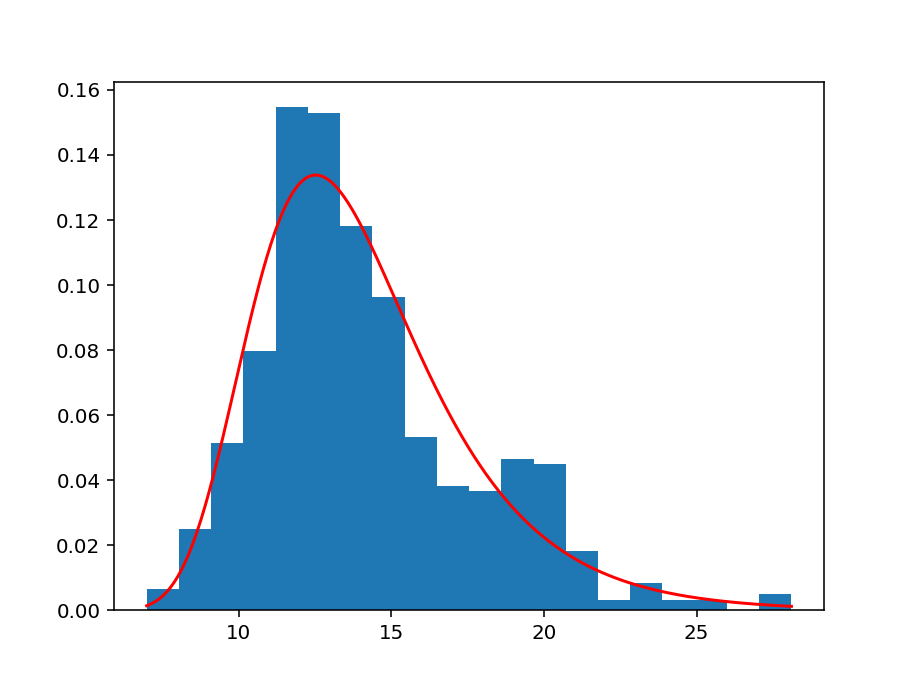

Mean of radius is 12.52641922554831
Mean considering Normal distribution: 14.127291739894552
Probability of tumor radius greater than 20: 6.428280073382242 [%]


18.726261532367737

In [66]:
#radius_std = (radius  - np.mean(radius))/np.std(radius)

# Define dist
dist = scipy.stats.genextreme
    
# get best pasrams using MLE
params = dist.fit(radius)

# Get dist with optimized params
fitted_dist = dist(*params[:-2], loc = params[-2], scale = params[-1])

fig, ax = plt.subplots()

ax.hist(radius, bins = 20, density = True)
ax.plot(x_plot, fitted_dist.pdf(x_plot), 'r-')

print('Mean of radius is {0}'.format(params[-2]))
print('Mean considering Normal distribution: {0}'.format(radius.mean()))

p2 = 1. - fitted_dist.cdf(20)

print('Probability of tumor radius greater than 20: {0} [%]'.format(p2*100))

p3 = fitted_dist.ppf(0.90)

p3

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(x, bins=20, density=True)
ax.set_xlabel('Tamaño del nodulo')
dist = scipy.stats.genextreme
params = dist.fit(x)
fitted_dist = dist(*params[:-2], loc=params[-2], scale=params[-1])
p_plot = fitted_dist.pdf(x_plot)
ax.plot(x_plot, p_plot, c='k', lw=2);
ax.fill_between(x_plot[x_plot>=20], np.zeros_like(x_plot[x_plot>=20]), p_plot[x_plot>=20], 
                alpha=0.5, color='k', zorder=20)

# P1: Usando el atributo mean() 
display(fitted_dist.mean())
# P2: Usando el atributo CDF
display(1. - fitted_dist.cdf(20))
# P3: Usando el atributo PPF
display(fitted_dist.ppf(0.9))

p-values: https://ipython-books.github.io/72-getting-started-with-statistical-hypothesis-testing-a-simple-z-test/

### Ejemplo: Clasificador Bayesiano Ingenuo

Tenemos un dataset de pacientes con cancer de mama 

Cada paciente está representado por
- x: radio de la muestra (continua)
- z: textura de la muestra (continua)
- y: etiqueta de la muestra (0:maligno o 1:benigno)

El dataset tiene 569 pacientes, 212 con tumores malignos(0) y 357 tumores benignos (1)

<IPython.core.display.Javascript object>


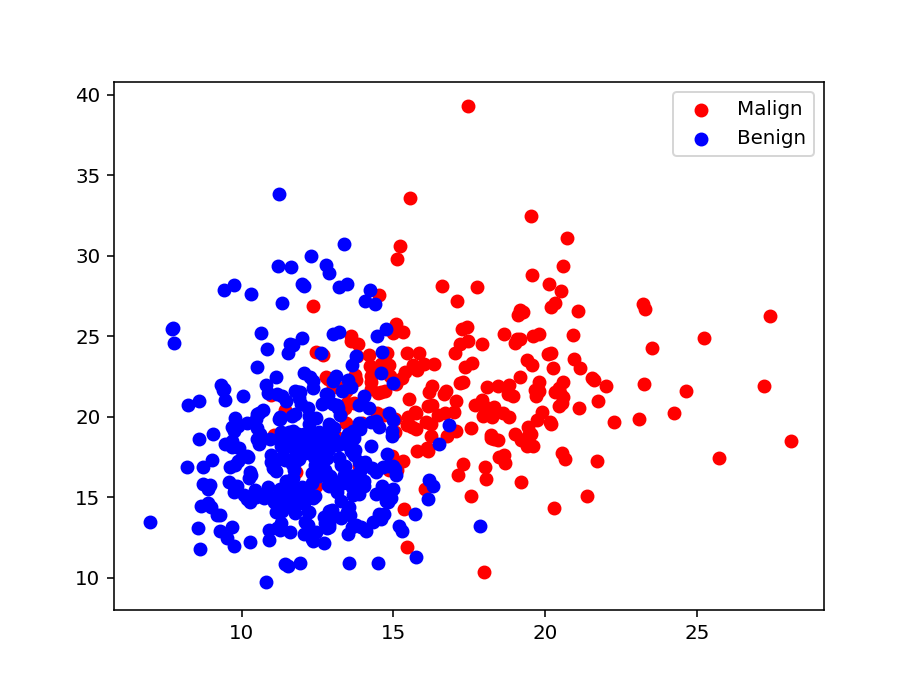

In [42]:
from sklearn import datasets
data_set = datasets.load_breast_cancer()

radius, texture, target = data_set['data'][:,0], data_set['data'][:,1], data_set['target']

fig, ax = plt.subplots()

ax.scatter(radius[target == 0], texture[target == 0], c = 'r', label = 'Malign')
ax.scatter(radius[target == 1], texture[target == 1], c = 'b', label = 'Benign')
#ax.scatter(radius, target, c = 'r', label = 'Malign')
#ax.scatter(radius[target == 1], c = 'b', label = 'Benign')
ax.legend()

<IPython.core.display.Javascript object>


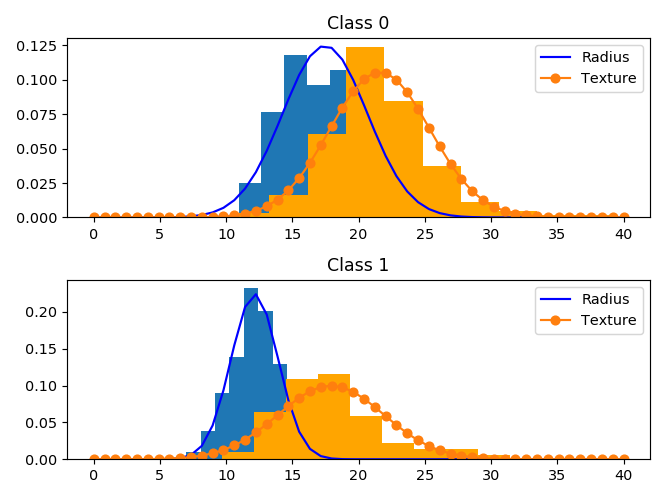

Class : 0


0.37258347978910367
[0.99999987]
[0.99999998]
probability class 0: 37.25834227329748


Class : 1


0.6274165202108963
[1.]
[0.99998881]
probability class 1: 62.740950163263356




 Results: 
Class: 1
Sklearn gaussian: [1 1]


In [229]:
from collections import Counter

# bayesian classifier


#prior probabilites
prior_prob = [Counter(target)[i]/len(target) for i in range(2)]

# Fitt distribution to each feature by class
# Class y = 0
fig, ax = plt.subplots(2,1, tight_layout = True)

# Assuming they have normal distribution

# Fitting normal dist
dist = scipy.stats.norm

radius_dist_list = []
texture_dist_list = []

x_plot = np.linspace(0, 40) 
# Iterate over each class
for class_val in range(2):
    
    # Get parameters
    params_radius = dist.fit(radius[target == class_val])
    params_texture = dist.fit(texture[target == class_val])

    # Getting distr and Store distribution
    radius_dist = dist(loc = params_radius[-2], scale = params_radius[-1])
    texture_dist = dist(loc = params_texture[-2], scale = params_texture[-1])

    radius_dist_list.append(radius_dist)
    texture_dist_list.append(texture_dist)
    
    # Plotting histogram
    ax[class_val].hist(radius[target == class_val], bins = 10, density = True)
    ax[class_val].hist(texture[target == class_val], bins = 10, density = True, color = 'orange')
    
    # Plotting fitted distr
    ax[class_val].plot(x_plot, radius_dist.pdf(x_plot), 'b-', label = 'Radius')
    ax[class_val].plot(x_plot, texture_dist.pdf(x_plot), 'o-', label = 'Texture')
    ax[class_val].legend()
    ax[class_val].title.set_text('Class ' + str(class_val))

# Apply naive bayes classifier

# new_obs = np.array([[12.],[17.1]]) # Tend to be class 0
new_obs = np.array([[1],[1]])

# Apply bayesian classifier
classifier = np.ones((2,1))

# print(clasiffier[1])

for class_val in range(2):
    
    print('Class : {0}\n\n'.format(class_val))
    #bayes_result[class_val] = prior_prob[class_val]*(1-radius_dist_list[class_val].cdf(new_obs[0]))*(1-texture_dist_list[class_val].cdf(new_obs[1]))
    A = prior_prob[class_val]
#     B = (1-radius_dist_list[class_val].pdf(new_obs[0]))
#     C = (1-texture_dist_list[class_val].pdf(new_obs[1]))
#     B = (radius_dist_list[class_val].pdf(new_obs[0])) # this give R > 1
#     C = (texture_dist_list[class_val].pdf(new_obs[1]))# this give R > 1

    B = (1- radius_dist_list[class_val].cdf(new_obs[0])) # classify with R = 649
    C = (1- texture_dist_list[class_val].cdf(new_obs[1])) # classify with R = 649

   # B = (radius_dist_list[class_val].cdf(new_obs[0])) # bad
    #C = (texture_dist_list[class_val].cdf(new_obs[1])) # bad
    
    print(A)
    print(B)
    print(C)
#     print(A*B*C)
    
    classifier[class_val] = A*B*C
    #print(A.shape)
    #print(B.shape)
    #print(C.shape)
    #print(prior_prob[class_val]*(1-radius_dist_list[class_val].cdf(new_obs[0]))*(1-texture_dist_list[class_val].cdf(new_obs[1])))

    print('probability class {0}: {1}\n\n'.format(class_val, classifier[class_val][0]*100))
   
R = 1
div = classifier[0]/classifier[1]
if(div > R):
    
    res = 0
    
else:
    
    res = 1
    
print('\n\n Results: \nClass: {0}'.format(res))

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(np.concatenate((radius.reshape(569,1), texture.reshape(569,1)), axis = 1), target).predict(new_obs)
print('Sklearn gaussian: {0}'.format(y_pred))

In [221]:
radius.shape

(569,)

<IPython.core.display.Javascript object>


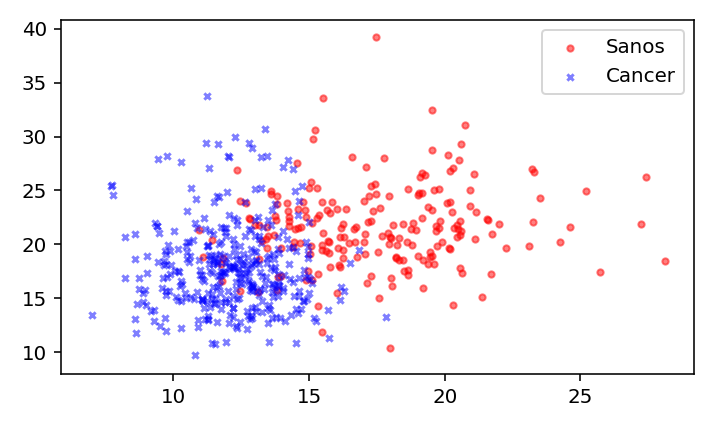

In [25]:
x, y = data_set['data'][:, :2], data_set['target']
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], c='r', s=10, marker='o', label='Sanos', alpha=0.5)
ax.scatter(x[y==1, 0], x[y==1, 1], c='b', s=10, marker='x', label='Cancer', alpha=0.5)
plt.legend();

Usando el teorema de Bayes podemos escribir la probabilidad de que el tumor sea benigno dada sus características (*posterior*) como

$$
p(y=1|x, z) = \frac{p(x, z|y=1) p(y=1)}{p(x, z)}
$$

y la probabilidad de que sea maligno como
$$
p(y=0|x, z) = \frac{p(x, z|y=0) p(y=0)}{p(x, z)}
$$

- Nos interesa saber si $p(y=0|x, z) > p(y=1|x, z)$
- La evidencia $p(x, z)$ es difícil de estimar 

Entonces

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} = \frac{p(x, z|y=1) p(y=1)}{p(x, z|y=0) p(y=0)}
$$

y los *priors*: $p(y=0) = \frac{212}{569} \approx 0.41$, $p(y=1) = \frac{357}{569} \approx 0.59$

Lo único que falta es la verosimilitud, asumiremos que

- las características son condicionalmente independientes
$$
p(x, z|y) = p(x|y) p(z|y)
$$
- las características son normales
$$
p(x|y) = \mathcal{N}(\mu_x, \sigma_x^2)
$$

Estos supuestos son lo que hacen al clasificador "ingenuo"

In [180]:
# Probabilidades a priori
from collections import Counter
py = [Counter(y)[i]/len(y) for i in range(2)]
# Ajuste de verosimilitudes
dists = {}
for y_ in [0, 1]: # Para cada clase
    for x_ in [0, 1]: # para cada característica
        params = scipy.stats.norm.fit(x[y==y_, x_])
        dists[(y_, x_)] = scipy.stats.norm(loc=params[-2], scale=params[-1])

def likelihoods(x, z):
    pxzy0 = dists[(0, 0)].pdf(x)*dists[(0, 1)].pdf(z)
    pxzy1 = dists[(1, 0)].pdf(x)*dists[(1, 1)].pdf(z)
    return pxzy0, pxzy1, (pxzy1*py[1])/(pxzy0*py[0])

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Sanos', 'Cancer'], ['o', 'x'])):
    ax.scatter(x[y==k, 0], x[y==k, 1], c='k', s=10, 
               marker=marker, label=label, alpha=0.5)

x_plot = np.linspace(np.amin(x[:, 0]), np.amax(x[:, 0]), num=500)
z_plot = np.linspace(np.amin(x[:, 1]), np.amax(x[:, 1]), num=500)
X, Z = np.meshgrid(x_plot, z_plot)
Y = likelihoods(X, Z)
ax.contourf(X, Z, Y[1] - Y[0], zorder=-1, cmap=plt.cm.RdBu, 
            vmin=-2e-2, vmax=2e-2, levels=20)
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
ax.set_xlabel('X'); ax.set_ylabel('Z');
plt.legend();

IndexError: too many indices for array

Decidimos entre sano y enfermo usando el cociente entre los posterior

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} > R
$$

Dos tipos de errores:
1. Predecir que está enfermo $\hat y=1$ cuando en realidad estaba sano $y=0$
1. Predecir que está sano $\hat y=0$ cuando en realidad estaba enfermo $y=1$

¿Las decisiones tienen igual riesgo ($R$=1) ? 

Podemos "calibrar" la importancia de las decisiones usando un $R$ mayor o menor que $1$

In [ ]:
ax.contour(X, Z, Y[2] > 1., zorder=-1, levels=[0]);
#ax.contour(X, Z, Y[2] > 0.5, zorder=-1, levels=[0]);
#ax.contour(X, Z, Y[2] > 0.1, zorder=-1, levels=[0]);

#### Resumen
- Cada clase es representada por una distribución Gaussiana
- Entrenamos cada Gaussiana por **máxima verosimilitud**
- El cociente entre los posterior nos da la clase más probable
- **Ventajas:** Fácil de entrenar, en general no se sobreajusta
- **Desventajas:** Supuestos fuertes, características independientes y probabilidades normales
- Podemos entrenar un clasificador para datos discretos si usamos distribuciones multinomiales
- Implementación en [scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [Más sobre clasificador bayesiano](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html)


### Ejemplo: Ajustando una recta

Sea el siguiente dataset de [consumo de helados](https://forge.scilab.org/index.php/p/rdataset/source/tree/master/csv/Ecdat/Icecream.csv) en USA

In [ ]:
!wget -nc -c https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/Ecdat/Icecream.csv
df = pd.read_csv('Icecream.csv', header=0, index_col=0)
df.columns = ['consumo', 'ingreso', 'precio', 'temperatura']
display(df.head())

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True, sharey=True)
for i, col in enumerate(df.columns[1:]):
    ax[i].scatter(df[col], df["consumo"])
    ax[i].set_xlabel(col)
ax[0].set_ylabel(df.columns[0])

Sea $y$ el consumo y $x$ la temperatura.

Asumiendo errores gaussianos

$$
y_i = \hat y_i + \epsilon_i, \epsilon_i \sim \mathcal{N}(0, \sigma^2),
$$

un modelo lineal de dos parámetros,

$$
\hat y_i = \theta_0 + \theta_1 x_i
$$

y observaciones iid, podemos estimar $\theta$ buscando la máxima verosimilitud del modelo

$$
\min_\theta \log \mathcal{L}(\theta) = \sum_{i=1}^M (y_i - \theta_0 - \theta_1 x_i)^2
$$

donde 
$$
\sum_i y_i  - M\theta_0 - \theta_1  \sum_i x_i = 0 \rightarrow \theta_0 = \bar y - \theta_1 \bar x
$$
$$
\sum_i y_i x_i - \theta_0 \sum_i x_i - \theta_1 \sum_i x_i^2 = 0
$$

$$
\theta_1 = \frac{\sum_i x_i y_i - M \bar x \bar y}{\sum_i x_i^2 - M \bar x^2} = \frac{ \sum_i (y_i - \bar y)(x_i - \bar x)}{\sum_i (x_i - \bar x)^2} = \frac{\text{COV}(x, y)}{\text{Var}(x)}
$$

la fuerza de la correlación se mide con 

$$
r^2 = 1 - \frac{\sum_i ( y_i - \hat y_i)^2}{\sum_i ( y_i - \bar y)^2} = 1 - \frac{\frac{1}{M} \sum_i (y_i - \hat y_i)^2}{\text{Var}(y)} = \frac{\text{COV}^2(x, y)}{\text{Var}(x) \text{Var}(y)}
$$

donde $r \in [0, 1]$ se conoce como [coeficiente de correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

Podemos usar pandas para calcular $r$

In [ ]:
df.corr()

Es decir que existe 
- una correlación positiva alta entre consumo y temperatura
- una correlación negativa moderada entre consumo y precio
- una correlación cercana a cero entre consumo e ingreso

Podemos usar la función [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) para recuperar $\theta_0$, $\theta_1$ y $r$

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True, sharey=True)
ax[0].set_ylabel(df.columns[0]);

for i, col in enumerate(df.columns[1:]):
    ax[i].scatter(df[col], df["consumo"])    
    res = scipy.stats.linregress(df[col], df["consumo"])
    ax[i].set_title("r: {0:0.5f}".format(res.rvalue))
    x_plot = np.linspace(np.amin(df[col]), np. amax(df[col]), num=100)
    ax[i].plot(x_plot, res.slope*x_plot + res.intercept, lw=4, alpha=0.5, c='k');
    ax[i].set_xlabel(col)

### Respondiendo preguntas con nuestro modelo

1. ¿Qué tan confiables son los valores de $\theta_0$, $\theta_1$ y $r$?
1. ¿Son las correlaciones encontradas significativas?


Dos caminos para responder
- Pruebas paramétricas
- Bootstrap

## Test de hipótesis

Algoritmo general para hacer test de hipótesis
1. Definimos una hipótesis nula y una hipótesis alternativa
1. Definimos un estadístico $t$ que sirva para verificar la hipótesis nula 
1. Asumimos una distribución para el estadístico bajo la hipótesis nula
1. Seleccionamos un nivel de significancia $\alpha$ 
1. Calculamos el estadístico para nuestros datos $t_{data}$
1. Calculamos el **p-value**: Probabilidad de observar un valor $t>t_{data}$
1. Rechazamos la hipótesis nula con confianza $1-\alpha$ si el p-value es menor que $\alpha$

### t-test para probar que la regresión es significativa

En este caso queremos hacer el siguiente test
- $H_0:$ La pendiente es nula $\theta_1= 0$ 
- $H_1:$ La pendiente no es nula: $\theta_1\neq 0$ 

Asumimos que $\theta_1$ es normal pero que desconocemos su varianza 

Podemos formular el siguiente estadístico de prueba

$$
t = \frac{(\theta_1-\theta^*) }{\text{SE}_{\theta_1}/\sqrt{M-2}} = \frac{ r\sqrt{M-2}}{\sqrt{1-r^2}},
$$

donde en este caso usaremos $\theta^*=0$ y $\text{SE}_{\theta_1} = \sqrt{ \frac{\frac{1}{M} \sum_i (y_i - \hat y_i)^2}{\text{Var}(x)}}$

$t$ se distribuye [t-student](https://en.wikipedia.org/wiki/Student%27s_t-distribution) con dos grados de libertad (modelo de dos parámetros) 

La función `scipy.stats.linregress` implementa este test y retorna los p-values

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True, sharey=True)
t = np.linspace(-7, 7, num=1000)
M = df.shape[0]
ax[0].set_ylabel(df.columns[0]);

for i, col in enumerate(df.columns[1:]):
    res = scipy.stats.linregress(df[col], df["consumo"])
    t_data = res.rvalue*np.sqrt(M-2)/np.sqrt(1.-res.rvalue**2)
    ax[i].set_title("t_data: {0:0.5f}".format(t_data))
    ax[i].set_xlabel(col)
    dist = scipy.stats.t(loc=0, scale=1, df=M-2)
    p = dist.pdf(t)
    ax[i].plot(t, p)
    ax[i].plot([dist.ppf(0.025)]*2, [0, np.amax(p)], 'k--')
    ax[i].plot([dist.ppf(0.975)]*2, [0, np.amax(p)], 'k--')
    ax[i].plot([t_data]*2, [0, np.amax(p)])

¿Qué podemos decir de las correlaciones con el consumo de helados?

Para temperatura y considerando $\alpha = 0.05$:

> $\text{p-value} = 4.7892e-07 < \alpha$

Por ende rechazamos $H_0$ con 95% de confianza

En cambio para ingreso y precio no podemos rechazar $H_0$

### Reflexión
- ¿Cómo se escogen el estadístico y la distribución de prueba? Depende del problema 
- ¿Qué prueba puedo usar si quiero hacer regresión lineal multivariada? [ANOVA](https://pythonfordatascience.org/anova-python/)
- ¿Qué pasa si mis datos tienen una relación que no es lineal? La prueba no es confiable
- ¿Qué pasa si $\theta_1$ no es normal? La prueba no es confiable
- ¿Qué pasa si el ruido no es Gaussiano? La prueba no es confiable
- ¿Qué pasa si el ruido es Gaussiano pero su varianza cambia en el tiempo? La prueba no es confiable

## Prueba no-paramétrica: *Bootstrap*

Podemos estimar la incerteza de un estimador de forma no-paramétrica usando **muestreo tipo *bootstrap***

Tomamos nuestros conjunto de datos de tamaño $M$ y creamos $T$ nuevos conjuntos que "se le parezcan" 

Luego se calcula el valor del estimador en esos nuevos conjuntos

*Bootstrap* está basado en la Ley de los grandes números y Teorema central del límite 

<img src="https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2016/10/bootstrap-sample.png">

- En este caso supondremos independencia: **Muestreo con reemplazo de tamaño $M$**
- También existe bootstrap basado en los residuos y bootstrap dependiente

Podemos usar la función [`numpy.random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) para generar los nuevos índices

In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, 2, figsize=(6, 5), tight_layout=True)
x, y = df["temperatura"].values, df["consumo"].values
x_plot = np.linspace(np.amin(x), np. amax(x), num=100)
res_all = scipy.stats.linregress(x, y)
M = len(x)

def update_plot(T):
    [ax_.cla() for ax_ in ax.ravel()]
    ax[0, 0].scatter(x, y, zorder=100, s=10)
    np.random.seed(0)
    param = np.zeros(shape=(T, 3))
    lines = []
    for t in range(T):
        bootstrap_idx = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
        res = scipy.stats.linregress(x[bootstrap_idx], y[bootstrap_idx])
        lines.append(x_plot*res.slope + res.intercept)
        #ax[0, 0].plot(x_plot, x_plot*res.slope + res.intercept, alpha=0.05, c='k')
        param[t, :] = [res.intercept, res.slope, res.rvalue]
    ax[0, 0].plot(x_plot, x_plot*res_all.slope + res_all.intercept, alpha=1, c='r')
    lines = np.stack(lines)
    ax[0, 0].fill_between(x_plot, np.mean(lines, axis=0)-3*np.std(lines, axis=0), 
                          np.mean(lines, axis=0)+3*np.std(lines, axis=0), color='r', alpha=0.25)
    hist_val, hist_lim, _ = ax[0, 1].hist(param[:, 2], bins=15, density=True)
    ax[0, 1].plot([res_all.rvalue]*2, [0, np.max(hist_val)], c='r')
    ax[0, 1].set_xlabel('r')
    display("Intervalo de confianza al 95% de r {}".format(np.percentile(param[:, 2], [2.5, 97.5])))
    hist_val, hist_lim, _ = ax[1, 0].hist(param[:, 0], bins=15, density=True)
    ax[1, 0].plot([res_all.intercept]*2, [0, np.max(hist_val)], c='r')
    ax[1, 0].set_xlabel(r'$\theta_0$')
    display("Intervalo de confianza al 95% de theta_0 {}".format(np.percentile(param[:, 0], [2.5, 97.5])))
    hist_val, hist_lim, _ = ax[1, 1].hist(param[:, 1], bins=15, density=True)
    ax[1, 1].plot([res_all.slope]*2, [0, np.max(hist_val)], c='r')
    ax[1, 1].set_xlabel(r'$\theta_1$')
    display("Intervalo de confianza al 95% de theta_1 {}".format(np.percentile(param[:, 1], [2.5, 97.5])))

widgets.interact(update_plot, T=SelSlider_nice(options=[10, 20, 50, 100, 200, 500], value=50));

- $\theta_1=0$ no está en el intervalo de confianza por lo que podemos rechazar $H_0$
- Notamos que $\theta_0$ y $\theta_1$ son asintóticamente normales. El supuesto del t-test estaba bien!
- Si hubieramos hecho un t-test sobre $r$ no sería valido (no normalidad)

Más sobre [*bootstrap* y regresión lineal](https://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf) [aquí](http://homepage.divms.uiowa.edu/~rdecook/stat3200/notes/bootstrap_4pp.pdf) y [acá](https://www.sagepub.com/sites/default/files/upm-binaries/21122_Chapter_21.pdf)

In [ ]:
!rm Icecream.csv

### Ejemplo: Regresión lineal multivariada y mínimos cuadrados

Queremos ajustar un modelo lineal de $N$ parámetros a un conjunto de $M$ observaciones ruidosas

Podemos modelar 

$$
y_i = \Phi(x_i) \theta + \varepsilon_i
$$

donde $\varepsilon_i \sim \mathcal{N}(0, \sigma_\varepsilon^2)$

Si asumimos que los datos son iid podemos escribir el logaritmo de la verosimilitud como

$$
\begin{align}
\log p(y_1, y_2, \ldots, y_M| \theta) &= \log \prod_{i=1}^M p(y_i|\theta) \nonumber \\
&=  -\frac{1}{2} \log(2\pi\sigma_\varepsilon^2) M - \frac{1}{2\sigma_\varepsilon^2} \sum_{i=1}^M (y_i - \Phi(x_i) \theta)^2
\end{align}
$$

el primer término no depende de $\theta$ y el segundo es negativo

El resultado de maximizar la log verosimilitud es equivalente a
$$
\min_\theta \log \mathcal{L}(\theta) = \sum_{i=1}^M (y_i - \Phi(x_i) \theta)^2
$$

Que corresponde al problema de **mínimos cuadrados**

#### Reflexionemos
¿Qué estamos asumiendo cuando usamos mínimos cuadrados?

# Maximum a posteriori (MAP)

- Hasta ahora nos hemos enfocado en la verosimilitud $p(\mathcal{D}|\theta)$
- En realidad lo que más nos interesa es el *posterior* $p(\theta|\mathcal{D})$

Bayes nos dice que

$$
p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta)p(\theta)}{p(\mathcal{D})}
$$

El criterio MAP busca encontrar $\theta$ que maximiza el posterior. 

Es decir la moda del posterior

Usando el logaritmo para escribir

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log p(\theta|\mathcal{D}) \nonumber \\
&= \text{arg}\max_\theta \log p(\mathcal{D}|\theta) + \log p(\theta) \nonumber
\end{align}
$$
donde omitimos la evidencia $p(\mathcal{D})$ ya que no depende de $\theta$

- El criterio MAP consiste en maximizar la **verosimilitud** más el **prior**
- Usamos el **prior** para agregar información sobre $\theta$


### Ejemplo: Regresión  con MAP

Quiero modelar una regresión de $N$ parámetros
$$
\begin{align}
y_i = & \Phi(x_i) \theta + \varepsilon_i \nonumber \\
&\varepsilon_i \sim \mathcal{N}(0, \sigma_\epsilon^2) \nonumber \\
&y_i|\theta \sim \mathcal{N}(\Phi(x_i) \theta, \sigma_\epsilon^2) \nonumber
\end{align}
$$
es decir **verosimilitud** Gaussiana tal como antes

Adicionalmente asumiremos que $p(\theta) = \mathcal{N}(0, \sigma_\theta^2)$, es decir **prior** Gaussiano

El estimador MAP es 

$$
\begin{align}
\hat \theta &= \text{arg} \max_\theta -\frac{1}{2} \log(2\pi\sigma_\varepsilon^2) M - \frac{1}{2\sigma_\varepsilon^2} \sum_{i=1}^M (y_i - \Phi(x_i) \theta)^2 -\frac{1}{2} \log(2\pi \sigma_\theta^2) N - \frac{1}{2\sigma_\theta^2} \sum_{j=1}^N \theta_j^2 \nonumber \\
&= \text{arg} \min_\theta  \sum_{i=1}^M (y_i - \Phi(x_i) \theta)^2 + \frac{\sigma_\varepsilon^2}{\sigma_\theta^2} \sum_{j=1}^N \theta_j^2 \nonumber 
\end{align}
$$


#### Reflexión
- Si hay mucho ruido ($\sigma_\varepsilon^2 \to \infty$) entonces ignoro la verosimilitud y le creo al prior
- Si uso un prior que no me da información ($\sigma_\theta^2 \to \infty$) entonces lo ignoro y me enfoco en la verosimilitud

#### Relación con lo visto sobre regularización

- Si decimos $\lambda = \frac{\sigma_\varepsilon^2}{\sigma_\theta^2}$ entonces la formulación es equivalente a Mínimos cuadrados regularizado, Ridge Regressión, Tikhonov!
- Si hubieramos asumido una distribución Laplaciana para $p(\theta)$ hubieramos obtenido el [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics))


# Inferencia Bayesiana

- Asumimos que $\theta$ es una variable aleatoria y que tiene cierta distribución
- Buscamos estimar el posterior completo $p(\theta|\mathcal{D})$
- El problema es que $p(\mathcal{D})$ es generalmente incalculable
- Para proseguir tenemos tres opciones
    1. Usar distribuciones que sean conjugadas
    1. Usar una aproximación (inferencia variacional)
    1. Aprender un sistema que se comporte como el posterior (Markov Chain Monte Carlo) 

In [ ]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

temperatura, consumo = df["temperatura"].values, df["consumo"].values
with pm.Model() as helados:
    sigma = pm.HalfNormal('sigma', sd=10, shape=1)
    theta0 = pm.Normal('intercept', mu=0, sd=10, shape=1)
    theta1 = pm.Normal('slope', mu=0, sd=10, shape=1)
    mu = temperatura*theta1 + theta0
    x_observed = pm.Normal('x_obs', mu=mu, sd=sigma, observed=consumo)
    trace = pm.sample(draws=500, tune=200, init='advi', n_init=30000, 
                      cores=4, chains=2, live_plot=False)
display(pm.summary(trace))
pm.traceplot(trace, figsize=(9, 6), combined=True);

Más sobre estos temas en el [repositorio de INFO337](https://github.com/magister-informatica-uach/INFO337/blob/master/MCMC/lecture.ipynb) del magíster de informática y en [Ipython](https://ipython-books.github.io/73-getting-started-with-bayesian-methods/) [cookbook](https://ipython-books.github.io/77-fitting-a-bayesian-model-by-sampling-from-a-posterior-distribution-with-a-markov-chain-monte-carlo-method/)

Para leer y reflexionar: 

https://www.sciencedirect.com/science/article/pii/S0167715218300737